In [4]:
# Import common libraries
import pandas as pd
from itertools import compress
from collections import defaultdict
from copy import deepcopy
from pprint import pprint
import os

# Import MNE processing
from mne.viz import plot_compare_evokeds
from mne import Epochs, events_from_annotations, set_log_level

# Import MNE-NIRS processing
import mne
from mne_nirs.channels import get_long_channels
from mne_nirs.channels import picks_pair_to_idx
from mne_nirs.datasets import fnirs_motor_group
from mne.preprocessing.nirs import beer_lambert_law, optical_density,\
    temporal_derivative_distribution_repair, scalp_coupling_index
from mne_nirs.signal_enhancement import enhance_negative_correlation

# Import MNE-BIDS processing
from mne_bids import BIDSPath, read_raw_bids

# Import StatsModels
import statsmodels.formula.api as smf

# Import Plotting Library
import matplotlib.pyplot as plt
import seaborn as sns

# Set general parameters
set_log_level("WARNING")  # Don't show info, as it is repetitive for many subjects

ignore = [".DS_Store", "sub-03"]

# Based on Guides Published Here
# https://mne.tools/mne-nirs/stable/auto_examples/general/plot_16_waveform_group.html

In [5]:
def individual_analysis(bids_path):

    # Read data with annotations in BIDS format
    # raw_intensity = read_raw_bids(bids_path=bids_path, verbose=False)
    raw_intensity = mne.io.read_raw_snirf(bids_path, verbose=True, preload=False)
    raw_intensity = get_long_channels(raw_intensity, min_dist=0.01)
    
    channel_types = raw_intensity.copy()
    print(channel_types)
    
    # raw_intensity.annotations.rename({'4': 'Control', '2': 'Neutral', '3': 'Inflammatory', '1':'Practice'})

    # Convert signal to optical density and determine bad channels
    raw_od = optical_density(raw_intensity)
    sci = scalp_coupling_index(raw_od, h_freq=1.35, h_trans_bandwidth=0.1)
    raw_od.info["bads"] = list(compress(raw_od.ch_names, sci < 0.5))
    # raw_od.interpolate_bads()

    # Downsample and apply signal cleaning techniques
    raw_od.resample(0.8)
    raw_od = temporal_derivative_distribution_repair(raw_od)

    # Convert to haemoglobin and filter
    raw_haemo = beer_lambert_law(raw_od, ppf=0.1)
    raw_haemo = raw_haemo.filter(0.02, 0.3,
                                 h_trans_bandwidth=0.1, l_trans_bandwidth=0.01,
                                 verbose=False)

    # Apply further data cleaning techniques and extract epochs
    raw_haemo = enhance_negative_correlation(raw_haemo)
    # Extract events but ignore those with
    # the word Ends (i.e. drop ExperimentEnds events)
    events, event_dict = events_from_annotations(raw_haemo, verbose=False)
    
    # Remove all STOP triggers to hardcode duration to 30 secs per MNE specs
    events = events[::2]
    print(events)

    epochs = Epochs(raw_haemo, events, event_id=event_dict, tmin=-1, tmax=15,
                    reject=dict(hbo=200e-6), reject_by_annotation=True,
                    proj=True, baseline=(None, 0), detrend=0,
                    preload=True, verbose=False)

    return raw_haemo, epochs

In [6]:
def individual_analysis(bids_path, trigger_id, variable_epoch_time, custom_triggers = False):
    """
    TLDR:
        This function takes in the file path to the BIDS directory and the dictionary that renames numeric triggers.
        This function returns raw haemodynamic (from the beer lambert function) data per MNE specs and epochs for the triggers.
    Examples of each variables:
        bids_path (str) = '../../LabResearch/IndependentStudy/DataAnalysis'
        trigger_id (dict) = {'4': 'Control', '2': 'Neutral', '3': 'Inflammatory', '1':'Practice'}
    Documentation:
        raw_haemo: https://mne.tools/stable/auto_tutorials/preprocessing/70_fnirs_processing.html#sphx-glr-auto-tutorials-preprocessing-70-fnirs-processing-py
        epochs: https://mne.tools/stable/generated/mne.Epochs.html#mne-epochs
    """
    # Read data with annotations in BIDS format
    # raw_intensity = read_raw_bids(bids_path=bids_path, verbose=False)
    raw_intensity = mne.io.read_raw_snirf(bids_path, verbose=True, preload=False)

    raw_intensity = get_long_channels(raw_intensity, min_dist=0.01)
    
    # Rename the numeric triggers for ease of processing later
    raw_intensity.annotations.rename(trigger_id)

    raw_haemo = quality_eval.signal_preprocessing(raw_intensity)

    # Apply further data cleaning techniques and extract epochs
    raw_haemo = enhance_negative_correlation(raw_haemo)

    
    if custom_triggers:
        # TODO: Need to add something here to be able to work in custom triggers
        print('We need to add code to handle custom triggers')
    else:
        events, event_dict = events_from_annotations(raw_haemo, verbose=False)

    # Logic splits here since there are fundamental differences in how we handle Epoch
    # generation in dynamic intervals instead of block intervals.
    if variable_epoch_time:
        epochs = dynamic_interval_tools.epoch_generation(raw_haemo, event_dict, events)
    else:
        # Remove all STOP triggers to hardcode duration to 30 secs per MNE specs
        #TODO: We'll need to remove this for all other datasets
        events = events[::2]
        
        epochs = Epochs(raw_haemo, events, event_id=event_dict, tmin=-1, tmax=15,
                        reject=dict(hbo=200e-6), reject_by_annotation=True,
                        proj=True, baseline=(None, 0), detrend=0,
                        preload=True, verbose=False)
        # Doing this to ensure that if variable_epoch_time is True or False the format
        # of the data remains the same.
        epochs = [epochs]

    return epochs, raw_haemo

Loading c:\Users\annal\Desktop\CSCI 5448 OOAD\mne_nirsexamples\2023-02-17_001.snirf
<RawSNIRF | 2023-02-17_001.snirf, 40 x 1716 (168.6 s), ~165 kB, data not loaded>


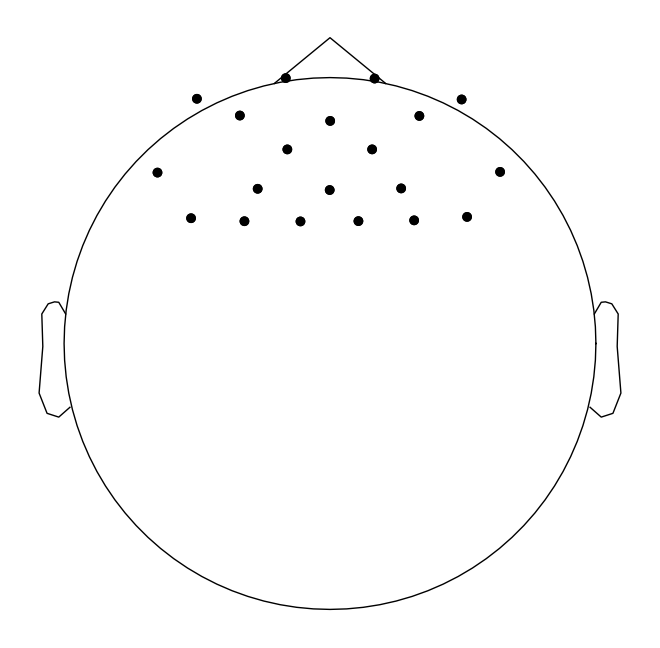

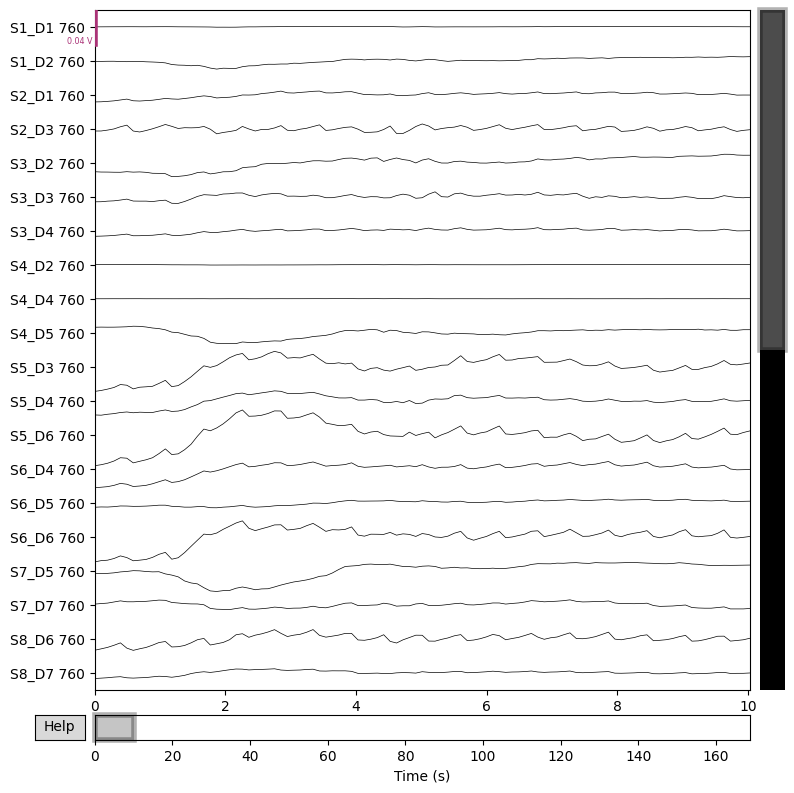

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.02 - 0.3 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.02
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.30 Hz
- Upper transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.35 Hz)
- Filter length: 265 samples (331.250 sec)

RAW HAEMO:  <RawSNIRF | 2023-02-17_001.snirf, 40 x 135 (167.5 s), ~207 kB, data loaded>


C:\Users\annal\AppData\Local\Temp\ipykernel_18740\3027112482.py:24: RuntimeWarning: filter_length (265) is longer than the signal (135), distortion is likely. Reduce filter length or filter a longer signal.
  raw_haemo = raw_haemo.filter(0.02, 0.3, h_trans_bandwidth=0.1, l_trans_bandwidth=0.01, verbose=True)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.0s finished


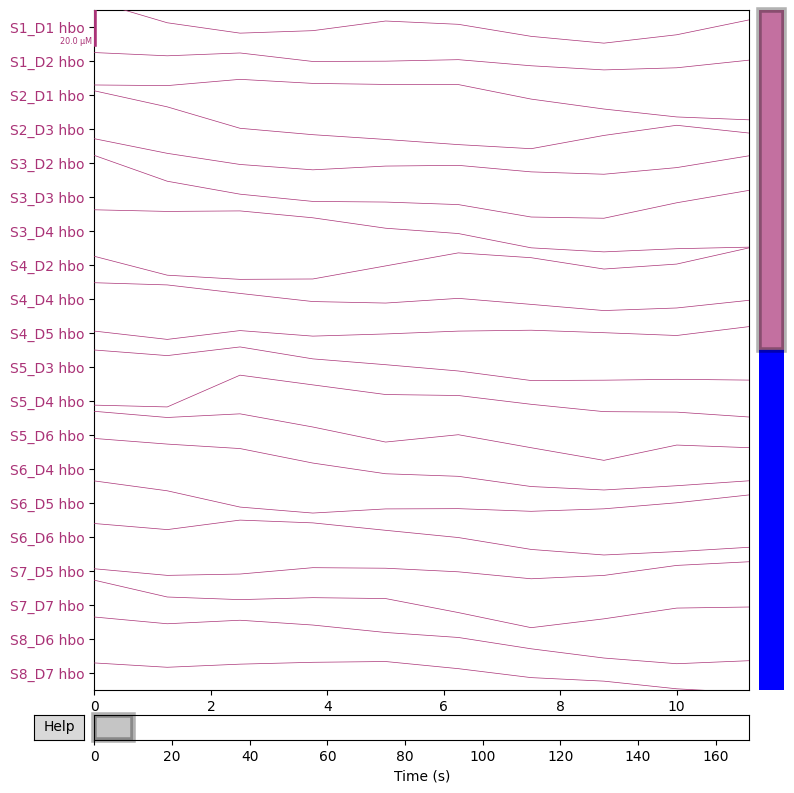

EVENTS:  []


ValueError: zero-size array to reduction operation maximum which has no identity

In [13]:
f_path = f'2023-02-17_001.snirf'

# Analyse data and return both ROI and channel results
raw_intensity = mne.io.read_raw_snirf(f_path, verbose=True, preload=False)
# raw_intensity = get_long_channels(raw_intensity, min_dist=0.01)

channel_types = raw_intensity.copy()
print(channel_types)
raw_intensity.plot_sensors()
raw_intensity.plot()
# spectrum = raw_intensity.compute_psd()
# spectrum.plot()
# spectrum.plot_topomap()

# raw_intensity.annotations.rename({'2': 'Concerning', '3': 'Neutral'})

raw_od = optical_density(raw_intensity)
sci = scalp_coupling_index(raw_od, h_freq=1.35, h_trans_bandwidth=0.1)

raw_od.resample(0.8)
raw_od = temporal_derivative_distribution_repair(raw_od)

raw_haemo = beer_lambert_law(raw_od, ppf=0.1)
raw_haemo = raw_haemo.filter(0.02, 0.3, h_trans_bandwidth=0.1, l_trans_bandwidth=0.01, verbose=True)
raw_haemo = enhance_negative_correlation(raw_haemo)
print("RAW HAEMO: ", raw_haemo)
# raw_haemo.compute_psd()
raw_haemo.plot()
events, event_dict = events_from_annotations(raw_haemo, verbose=False)

events = events[::2]
print("EVENTS: ", events)

# epochs = Epochs(raw_haemo, events, event_id=event_dict, tmin=-1, tmax=15,
#                     reject=dict(hbo=200e-6), reject_by_annotation=True,
#                     proj=True, baseline=(None, 0), detrend=0,
#                     preload=True, verbose=False)